## DBSCAN in PySpark


Density-based spatial clustering of applications with noise (DBSCAN) is a data clustering algorithm proposed by Martin Ester, Hans-Peter Kriegel, Jörg Sander and Xiaowei Xu in 1996.(WIKI) It is powerful clustering while dealing with dataset that has specific curves like circle and robust to outliers. We use it in many cases and it is popular in scikit-learn.          
However,in most recent Spark version(2.2.0), the MLlib only supports clustering algorithms including K-means, Latent Dirichlet allocation(LDA), Bisecting k-means and Gaussian Mixture Model (GMM)these 4 methods.            
In this notebook, I build DBSCAN model in PySpark so we can use it deal with big data.    
More about DBSCAN : https://en.wikipedia.org/wiki/DBSCAN
   

## Challenges
In the distributed environment, the sample points are distributed in different partitions, so it is difficult to traverse directly between different partitions. To solve this problem,we divide the partitions of different sample points into multiple batches and pull them to the driver, then <b>broadcast them to each excutor in turn</b>, calculate the distance respectively, and union the final result, so as to indirectly realize double traversal.

In the distributed environment, provisional clustering clusters are distributed in different partitions, so it is impossible to directly scan the global core point list and merge clusters having the same core points.
To do this, <b>merge each provisional cluster within each partition, then reduce the number of partitions and repartition, and then merge each provisional cluster within each partition. Repeat this process continuously,</b> and finally divide all temporary clusters into one partition to complete the merging of all temporary clusters.

## Initialization

In [1]:
import pyspark 
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel 
import numpy as np
import pandas as pd
from sklearn import datasets
# use local config but the algorithm dealing with distributed dataset
spark = SparkSession.builder \
        .appName("dbscan") \
        .config("master","local") \
        .enableHiveSupport() \
        .getOrCreate()

sc = spark.sparkContext

## Distribute DBSCAN

### Prepare dataset

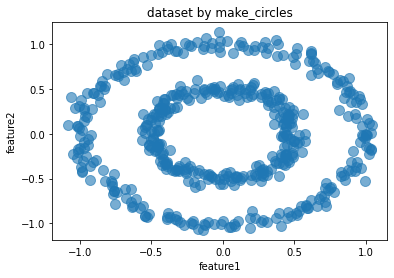

In [2]:
from sklearn import datasets
# prepare dataset
X,_ = datasets.make_circles(n_samples=500, factor=0.5, noise=0.05, random_state=10)
pdf = pd.DataFrame(X,columns = ['feature1','feature2'])
pdf.plot.scatter('feature1','feature2', s = 100,alpha = 0.6, title = 'dataset by make_circles')
pdf.to_csv("./data/make_circles_dataset.csv",sep = "\t",index = False)

### 1. Calculate distance

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import pandas as pd

#set parameters
eps = 0.2
min_samples=10

#transform in DataFrame type
dfdata = spark.read.option("header","true")\
  .option("inferSchema","true") \
  .option("delimiter", "\t") \
  .csv("data/make_circles_dataset.csv")

#combine features into array,and generate unique ID
dfinput = spark.createDataFrame(dfdata.selectExpr("array(feature1,feature2) as point") \
    .rdd.map(lambda row:row["point"]).zipWithIndex()).toDF("point","id") \
    .selectExpr("id","point").persist(StorageLevel.MEMORY_AND_DISK)

dfinput.show(truncate= False) 

+---+--------------------------------------------+
|id |point                                       |
+---+--------------------------------------------+
|0  |[-0.7722772142377522, -0.553017570417137]   |
|1  |[-0.1020787815097237, -0.46321960103505777] |
|2  |[-0.6868790108014708, -0.6119538443946839]  |
|3  |[0.07498635160016764, -1.0065812145933644]  |
|4  |[-1.010127817370748, -0.19791086274846176]  |
|5  |[0.07051607993999442, 0.5257843923353527]   |
|6  |[0.44326253556302186, 0.16373550820775043]  |
|7  |[0.5154155277186758, -0.10555331799076892]  |
|8  |[-0.7504275466865233, -0.7805127894258842]  |
|9  |[0.39070607564304016, 0.4104017775599596]   |
|10 |[0.23549479857186018, -0.4685195793105426]  |
|11 |[-0.6420899182299514, -0.6140068263121194]  |
|12 |[-0.5174270048377821, -0.8924508990314963]  |
|13 |[0.6849876665937729, -0.693386576612443]    |
|14 |[-0.40709284003797347, 0.26931763462472097] |
|15 |[-0.026185332951246865, -0.5094024561202708]|
|16 |[0.5156604466676297, 0.962

To accelerate the calculation, using KDTree to generate rough estimated results.

In [4]:
import numpy as np 
from pyspark.sql import types as T
from pyspark.sql import functions as F 
from pyspark.sql import Row,DataFrame
from sklearn.neighbors import KDTree

def fn(iterator):
    list_res = [] #m_id,s_id,m_point,s_point
    idxs_i,points_i,tree_i = broad_i.value
    for row in iterator:
        s_id = row["id"]
        s_point = row["point"]
        index = tree_i.query_radius(np.array([s_point]), r=2*eps)[0] #using kdtree search points in specified range
        for j in index:
            list_res.append([idxs_i[j],s_id,points_i[j],s_point])
    return iter(list_res)

rdd_input = dfinput.rdd.repartition(20).persist(StorageLevel.MEMORY_AND_DISK)


schema = T.StructType([
        T.StructField("m_id", T.LongType(), True),
        T.StructField("s_id", T.LongType(), True),
        T.StructField("m_point", T.ArrayType(T.DoubleType(),False), True),
        T.StructField("s_point", T.ArrayType(T.DoubleType(),False), True)])
 
dfpair_raw = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)


# partition data into 10, and broadcast iteratively
partition_cnt = 10
dfmaster = dfinput.repartition(partition_cnt)

for i in range(0,partition_cnt):
    rdd_master_i = dfmaster.rdd.mapPartitionsWithIndex(
        lambda idx, iterator: iterator if (idx == i ) else iter([]) )
    master_i = rdd_master_i.collect()
    idxs_i = [x["id"] for x in master_i]
    points_i = [x["point"] for x in master_i]
    tree_i = KDTree(np.array(points_i), leaf_size=40, metric='minkowski') #construct kdtree
    broad_i = sc.broadcast((idxs_i,points_i,tree_i))
    
    
    
    dfpair_raw_i = spark.createDataFrame(rdd_input.mapPartitions(fn)).toDF("m_id","s_id","m_point","s_point")
    dfpair_raw = dfpair_raw.union(dfpair_raw_i)

In [5]:
dfpair_raw.show(3,truncate= False)

+----+----+------------------------------------------+-----------------------------------------+
|m_id|s_id|m_point                                   |s_point                                  |
+----+----+------------------------------------------+-----------------------------------------+
|435 |190 |[0.425881475983358, 0.018041701646116598] |[0.4343398933561436, -0.2384673118794143]|
|206 |190 |[0.45251880064478056, 0.16020166433066324]|[0.4343398933561436, -0.2384673118794143]|
|71  |190 |[0.41781854101947136, -0.3338910366742408]|[0.4343398933561436, -0.2384673118794143]|
+----+----+------------------------------------------+-----------------------------------------+
only showing top 3 rows



In [6]:
dfpair_raw.count()

24404

Based on DBSCAN neighborhood radius (eps), confirm all connected pairs

In [7]:
# based on DBSCAN neighborhood radius (eps), confirm all connected pairs

spark.udf.register("distance", lambda p,q: sum(map(lambda x,y: (x-y)**2, p, q))**0.5 )
dfpair = dfpair_raw.where("distance(s_point,m_point) <"+str(eps)) \
    .persist(StorageLevel.MEMORY_AND_DISK)

dfpair.show(5,truncate=False)

+----+----+-------------------------------------------+-----------------------------------------+
|m_id|s_id|m_point                                    |s_point                                  |
+----+----+-------------------------------------------+-----------------------------------------+
|71  |190 |[0.41781854101947136, -0.3338910366742408] |[0.4343398933561436, -0.2384673118794143]|
|87  |191 |[-0.027973316098180295, 0.9739713571651403]|[0.11306867140044234, 0.9865653508360751]|
|371 |191 |[0.22215925132355654, 0.9835346114076869]  |[0.11306867140044234, 0.9865653508360751]|
|477 |191 |[0.13037103830734675, 1.0289553340970283]  |[0.11306867140044234, 0.9865653508360751]|
|53  |192 |[0.11744174319119184, 0.49754349638107787] |[0.2134351328529383, 0.5493264850818464] |
+----+----+-------------------------------------------+-----------------------------------------+
only showing top 5 rows



In [8]:
dfpair.count()

11148

### 2. Provisional Clusters

In [9]:
dfcore = dfpair.groupBy("s_id").agg(
  F.first("s_point").alias("s_point"),
  F.count("m_id").alias("neighbour_cnt"),
  F.collect_list("m_id").alias("neighbour_ids")
).where("neighbour_cnt>="+str(min_samples)) \
 .persist(StorageLevel.MEMORY_AND_DISK)

dfcore.show(3)

+----+--------------------+-------------+--------------------+
|s_id|             s_point|neighbour_cnt|       neighbour_ids|
+----+--------------------+-------------+--------------------+
|  26|[0.82859093883427...|           18|[218, 99, 112, 33...|
|  29|[-0.3093789470205...|           30|[390, 380, 29, 47...|
| 474|[-1.0043129304203...|           13|[474, 271, 385, 2...|
+----+--------------------+-------------+--------------------+
only showing top 3 rows



In [10]:
dfcore.count()

499

In [11]:
# get all connections among core points 
dfpair_join = dfcore.selectExpr("s_id").join(dfpair,["s_id"],"inner")
df_fids = dfcore.selectExpr("s_id as m_id")
dfpair_core = df_fids.join(dfpair_join,["m_id"],"inner")

rdd_core = dfpair_core.groupBy("s_id").agg(
  F.min("m_id").alias("min_core_id"),
  F.collect_set("m_id").alias("core_id_set")
).rdd.map(lambda row: (row["min_core_id"], set(row["core_id_set"])))

rdd_core.persist(StorageLevel.MEMORY_AND_DISK)

print("before_dbscan, rdd_core.count() = ",rdd_core.count())

before_dbscan, rdd_core.count() =  499


## 3. Merge Provisional clusters

In [12]:
# merge function, merge culsters share the core points
def mergeSets(list_set):
    result = []
    while  len(list_set)>0 :
        cur_set = list_set.pop(0)
        intersect_idxs = [i for i in list(range(len(list_set)-1,-1,-1)) if cur_set&list_set[i]]
        while  intersect_idxs :
            for idx in intersect_idxs:
                cur_set = cur_set|list_set[idx]

            for idx in intersect_idxs:
                list_set.pop(idx)
                
            intersect_idxs = [i for i in list(range(len(list_set)-1,-1,-1)) if cur_set&list_set[i]]
        
        result = result+[cur_set]
    return result
'''
Partition provisional cluster data(rdd_core), dealing with partitions parallelly, 
gradually reduce the number of partitions, and finally merge into one partition

If the data scale is too large and it is difficult to merge into one partition, 
it can also be finally reduced into several partitions to obtain approximate results 
'''
#rdd: (min_core_id,core_id_set)
def mergeRDD(rdd,partition_cnt):
    def fn(iterator):
        list_set = [x[1] for x in iterator]
        list_set_merged = mergeSets(list_set)
        merged_core = [(min(x),x) for x in list_set_merged] 
        return(iter(merged_core))
    rdd_merged = rdd.partitionBy(partition_cnt).mapPartitions(fn)
    return rdd_merged


#this part is important, the iteration times and parition should be adjust based on executors
for pcnt in (16,8,4,1):
    rdd_core = mergeRDD(rdd_core,pcnt)
    
rdd_core.persist(StorageLevel.MEMORY_AND_DISK)

print("after dbscan: rdd_core.count()=",rdd_core.count())

after dbscan: rdd_core.count()= 2


## 4. Organize the information of each cluster

In [13]:
dfcluster_ids = spark.createDataFrame(
    rdd_core.flatMap(lambda t: [(t[0], s_id) for s_id in t[1]])).toDF("cluster_id","s_id")

dfclusters =  dfcore.join(dfcluster_ids, "s_id", "left")

dfclusters.show(10) 

+----+--------------------+-------------+--------------------+----------+
|s_id|             s_point|neighbour_cnt|       neighbour_ids|cluster_id|
+----+--------------------+-------------+--------------------+----------+
|  26|[0.82859093883427...|           18|[218, 99, 112, 33...|         0|
|  29|[-0.3093789470205...|           30|[390, 380, 29, 47...|         1|
| 474|[-1.0043129304203...|           13|[474, 271, 385, 2...|         0|
| 191|[0.11306867140044...|           14|[87, 371, 477, 19...|         0|
| 418|[-0.0974069572587...|           32|[294, 1, 418, 21,...|         1|
|  65|[0.29595026744557...|           28|[53, 413, 54, 132...|         1|
| 222|[0.45175711723179...|           16|[207, 222, 260, 4...|         0|
| 270|[-0.1987550983252...|           28|[380, 495, 29, 36...|         1|
| 293|[-0.2459597915731...|           27|[314, 1, 418, 237...|         1|
| 243|[-0.4484303204507...|           32|[340, 475, 390, 4...|         1|
+----+--------------------+-----------

In [14]:
rdd_cluster = dfclusters.rdd.map(
    lambda row: (row["cluster_id"],(row["s_point"],row["neighbour_cnt"],set(row["neighbour_ids"])))
)

def reduce_fn(a,b):
    id_set = a[2]|b[2]
    result = (a[0],a[1],id_set) if a[1]>=b[1] else (b[0],b[1],id_set)
    return result

rdd_result = rdd_cluster.reduceByKey(reduce_fn)

def map_fn(t):
    cluster_id = t[0]
    representation_point = t[1][0]
    neighbour_points_cnt = t[1][1]
    id_set = list(t[1][2])
    cluster_points_cnt = len(id_set)
    return (cluster_id,representation_point,neighbour_points_cnt,cluster_points_cnt,id_set)

dfresult = spark.createDataFrame(rdd_result.map(map_fn)
    ).toDF("cluster_id","representation_point","neighbour_points_cnt","cluster_points_cnt","cluster_points_ids")

dfresult.persist(StorageLevel.MEMORY_AND_DISK)

dfresult.show(3)

+----------+--------------------+--------------------+------------------+--------------------+
|cluster_id|representation_point|neighbour_points_cnt|cluster_points_cnt|  cluster_points_ids|
+----------+--------------------+--------------------+------------------+--------------------+
|         0|[0.61730187542542...|                  20|               250|[0, 2, 3, 4, 8, 1...|
|         1|[0.48650052485245...|                  36|               250|[1, 5, 6, 7, 9, 1...|
+----------+--------------------+--------------------+------------------+--------------------+



### 5. Save results and Visualization

In [15]:
rdd_clusterid = dfresult.select("cluster_id","cluster_points_ids").rdd.flatMap(
    lambda t: [(x,t["cluster_id"]) for x in t["cluster_points_ids"]])

df_clusterid = spark.createDataFrame(rdd_clusterid).toDF("id","cluster_id")
dfoutput_raw = dfinput.join(df_clusterid,"id","left")
dfoutput = dfoutput_raw.na.fill(-1)

dfoutput = dfoutput.selectExpr("id","cluster_id","point[0] as feature1","point[1] as feature2")
dfoutput.persist(StorageLevel.MEMORY_AND_DISK)
dfoutput.show()

+---+----------+--------------------+--------------------+
| id|cluster_id|            feature1|            feature2|
+---+----------+--------------------+--------------------+
| 26|         0|  0.8285909388342712|  -0.473167893767672|
| 29|         1| -0.3093789470205048|  0.4348100124878411|
|474|         0| -1.0043129304203862| 0.06125112784701912|
| 65|         1|  0.2959502674455705|  0.4682366362816355|
|191|         0| 0.11306867140044234|  0.9865653508360751|
|418|         1|-0.09740695725876357|-0.45424415332659007|
|222|         0|  0.4517571172317956| -0.9451629376979882|
|270|         1|-0.19875509832527846| 0.45659956217152486|
|293|         1| -0.2459597915731778| -0.5222979334521255|
|243|         1| -0.4484303204507471|  0.2841735074916029|
|278|         1| 0.09840076046144647| -0.4874508187219382|
|367|         1|-0.25274265783769917| 0.39624468235985855|
|442|         0| -0.6701943854060299|  0.7239379219440983|
| 19|         0|   0.513085677374949| -0.880457982241908

In [16]:
'''
dfoutput.write.format("csv") \
  .option("header","true")\
  .option("inferSchema","true") \
  .option("delimiter", "\t") \
  .save("./data/dbscan_output.csv")
'''

'\ndfoutput.write.format("csv")   .option("header","true")  .option("inferSchema","true")   .option("delimiter", "\t")   .save("./data/dbscan_output.csv")\n'

<AxesSubplot:title={'center':'pyspark DBSCAN cluster result'}, xlabel='feature1', ylabel='feature2'>

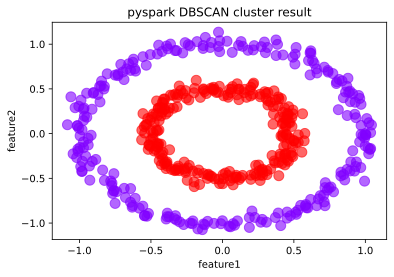

In [17]:
pdfoutput = dfoutput.toPandas()
pdfoutput.plot.scatter('feature1','feature2', s = 100,
    c = list(pdfoutput['cluster_id']),cmap = 'rainbow',colorbar = False,
    alpha = 0.6,title = 'pyspark DBSCAN cluster result')

### Compare with Sklearn results

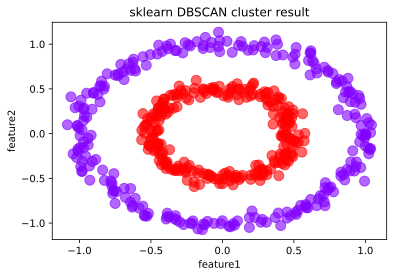

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.cluster import dbscan


core_samples,cluster_ids = dbscan(X, eps = 0.2, min_samples=10) 

pdf = pd.DataFrame(np.c_[X,cluster_ids],columns = ['feature1','feature2','cluster_id'])
pdf['cluster_id'] = pdf['cluster_id'].astype('int')

pdf.plot.scatter('feature1','feature2', s = 100,
    c = list(pdf['cluster_id']),cmap = 'rainbow',colorbar = False,
    alpha = 0.6,title = 'sklearn DBSCAN cluster result');